# Оценка стоимости экзотического опциона

### Предпосылки:

Срок: 5 лет

Корзина бумаг: AAPL (Apple), NVDA (Nvidia), AMD (AMD), INTC (Intel)

Выплаты по опциону:
1 год     выплачивается 10% номинала опциона, если стоимости всех бумаг выше начальных (фиксируются при покупке опциона на текущих рыночных уровнях), иначе купон «запоминается» для выплаты в последующем (механизм WorstOf с memory-купоном)

2 год     выплачивается 10% номинала опциона + все невыплаченные ранее, если стоимости всех бумаг выше начальных

3 год     выплачивается 10% номинала опциона + все невыплаченные ранее, если стоимости всех бумаг выше начальных

4 год     выплачивается 10% номинала опциона + все невыплаченные ранее, если стоимости всех бумаг выше начальных

5 год     выплачивается 10% номинала опциона + все невыплаченные ранее, если стоимости всех бумаг выше начальных

Начальные инвестиции: 1000 USD

Метод формирования бумаг в портфеле: Capital Asset Pricing Model (CAPM)

Минимальный вес бумаги в портфеле: 1%

Способ подсчета волатильности: историческая

Безрисковая ставка: 5 year treasury yield (2,65%)

Корреляция бумаг в портфеле: постоянная

Дивидендная доходноность бумаг на основании forward yield: NVDA - 0,24%, AAPL - 1,41%, AMD - 0,0%, INTC - 2,36% (Yahoo Finance)

Исторический горизонт для расчента волатильности и средней доходности: (2016-01-01, 2017-12-31)

### Импортируемые модули и их версии для проверки совместимости:

python 3.6.1
pandas: 0.22.0
pandas_datareader: 0.6.0
numpy: 1.14.2
matplotlib: 2.2.0
scipy: 1.0.0
sklearn: 0.19.1

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader
import pandas_datareader.data as web
import matplotlib
import matplotlib.pyplot as plt
import random
import scipy
import scipy.linalg as sl
import scipy.optimize as sco
import scipy.stats as scs
import sklearn
from sklearn.preprocessing import RobustScaler

plt.style.use('ggplot')

print('pandas: ' + str(pd.__version__))
print('pandas_datareader: ' + str(pandas_datareader.__version__))
print('numpy: ' + str(np.__version__))
print('matplotlib: ' + str(matplotlib.__version__))
print('scipy: ' + str(scipy.__version__))
print('sklearn: ' + str(sklearn.__version__))

pandas: 0.22.0
pandas_datareader: 0.6.0
numpy: 1.14.2
matplotlib: 2.2.0
scipy: 1.0.0
sklearn: 0.19.1


## Описание класса Basket

Класса **Basket** инициализируется с параметрами опциона, содержит всю информацию о исходных параметрах и результатах исполнения функций

**Аттрибуты класса:

a) *stock_list* - список тикетов акций 

b) *coupon* -  размер купона (выплаты купона привязаны к nominal value соотвечствующего периода)

c) *maturity* -  срок опциона в годах

d) *memory* - механизм "запоминания" невыплаченных купонных выплат

e) *data_range* - временной отрезок для выгрузки исторических данных

f) *risk_free* - безрисковая ставка

g) *n_trials* - количество попыток в Monte-Carlo simulations

h) *nominal* - первоночальный портфель в USD 

**Класс обладает 4 методами:

1) *import_data()* - импортирует данные через API

2) *monte_carlo(weights=[], div_yield = [])* - подсчитывает стоимость опциона, обладает двумя параметрами: weights - веса в исходном портфеле (если не предоставлено, считает исходя из портфеля CAPM, div_yield - ожидаемая постояннвя дивидентная доходность (если не предоставлено, считается равным 0)

   Метод возвращает кортеж со следущей информацией:
   
   a) средняя цена опциона
   
   b) цена опциона в каждом из trial
   
   c) результаты моделирования движения каждой из акций при risk neutral valuation (no arbitrage condition)
   
   d) результаты динамики каждого актива в портфеле и самого портфеля в каждом trial 

3) *greeks(plot = True)* - подсчитывает delta, gamma и speed у опциона, параметр plot отвечает за вывод визуализации

4) *summary_plot()* - результирующие графики и данные по опциону и портфелю акций

In [2]:
class Basket(object):
    def __init__(self, coupon, maturity, risk_free, nominal, stock_list = [], data_range = [], 
                 memory = True, n_trials = 10):
        self.stock_list = stock_list # list of securities
        self.coupon = coupon # coupon rate %
        self.maturity = maturity # maturity in years
        self.memory = memory # boolean memory of coupon for subsequent years
        self.data_range = data_range # format 'YYYY-MM-DD'
        self.risk_free = risk_free # applicable risk-free rate
        self.trials = n_trials # number of trials in monte carlo simulations
        self.n = len(stock_list) # number of stocks
        self.risk_free_vector = np.full((self.n,), risk_free) #risk free vector
        self.nominal = nominal # USd nominal value of the underlying portfolio 
    '''
    Import initial data for calculation   
    '''
    def import_data(self):
        
        self.data = pd.DataFrame()
        for stock in self.stock_list:
            s = pd.DataFrame(web.DataReader(stock, 'iex', self.data_range[0], self.data_range[1])['close']).rename(columns = {'close': stock}) 
            self.data = pd.concat([self.data, s], axis = 1)
        # convert index to date
        self.data.index = pd.to_datetime(self.data.index)
        # beginning price vector: last close prices
        self.S_beg = self.data.iloc[-1,:] 
        
        def cov_matrix(d = 252): # 252 business days for annualization
            # calculated returns
            self.ret = pd.DataFrame()        
            for stock in self.stock_list:
               s = self.data[stock].pct_change()
               self.ret = pd.concat([self.ret, s], axis = 1)
            
            # drop NA values
            self.ret.dropna(inplace = True)            
            # covariance matrix
            cov_matrix  = np.cov(self.ret.values.T)*d
            # variance
            variance = np.var(self.ret.values.T, axis = 1)*d
        
            return cov_matrix, variance
        
        self.cov_matrix , self.variance = cov_matrix()
        
    # Monte-Carlo simulations
    def monte_carlo(self, weights=[], div_yield = []):
        
        # Vector of dividend yields
        if div_yield == []:
            self.div_yield = np.full((self.n,), 0)
        else:
            if len(div_yield) != self.n:
                raise ValueError('Vector of dividends yield is not equal to number of stocks')
            else:
                self.div_yield = div_yield
            
        #Random walk simulation
        def random_path():
            
            # Cholesky decomposition of covariance matrix
            def cholesky_decomposition():
                L = sl.cholesky(self.cov_matrix)
                    
                return L
            
            # Random normal correlated variables simulation       
            def random_correlated():
                Z = [random.normalvariate(0,1) for i in range(self.n)]
                Y = np.dot(cholesky_decomposition(),Z)
                
                return Y.T
            t = 0
            self.path = np.array(self.S_beg) # beginning vector of prices
            S = self.S_beg
            
            while t < self.maturity: # random walk generator
                # Stocks random path
                S = S*np.exp((self.risk_free_vector -self.div_yield - self.variance/2.)+
                             random_correlated())
                self.path = np.append(self.path, [S])
                t = t + 1
            self.path = pd.DataFrame(self.path.reshape(self.maturity+1, self.n))  
            
            return self.path
        '''
        Calculate efficient portfolio weights as the optimal portfolio for the option underlyings 
        if weights are not provided
        '''
        # efficient portfolio calculation
        def efficient_portfolio(d = 252): # 252 business days for annualization
            #return of stocks
            ret = [(scs.gmean(self.ret[stock]+1, axis = 0)-1)*d for stock in self.stock_list]
            # bounds of stocks weights in the portfolio       
            bound = (0.01, 1) # minimum weight is 1%
            bounds = tuple(bound for stock in range(self.n))
            args = (ret, self.cov_matrix, self.risk_free)
            
            # annualized portfolio performance
            def portfolio_annualized_performance(weights):
                returns = np.sum(ret*weights)
                std = np.sqrt(np.dot(weights, np.dot(self.cov_matrix, weights)))
                
                return std, returns
            
            # function to minimize        
            def neg_sharpe_ratio(weights, ret, cov_matrix, risk_free):
                p_var, p_ret = portfolio_annualized_performance(weights)
                
                return -(p_ret - self.risk_free) / p_var
            
            constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
            # minimization problem
            result = sco.minimize(neg_sharpe_ratio, self.n*[1/self.n,], 
                                  method = 'SLSQP', bounds = bounds, args = args,
                                  constraints = constraints)
            return result.x
        
        '''
        Choose between provided and optimal weights in the porfolio
        '''
        if weights == []:
            self.weights = efficient_portfolio()
        else:
            if len(weights) != self.n:
                raise ValueError('Weights range does not match number of stocks')
            if np.sum(weights) != 1:
                raise ValueError('Weights sum does not sum to 1')
            else:
                self.weights = weights
        # number of stocks purchased        
        def number_of_stocks():
            number = [self.nominal*self.weights[i]/self.S_beg[i] for i in range(self.n)]
            
            return number
        self.monte_carlo_table = pd.DataFrame()
        self.option_price_table = np.array([])
        self.portfolio = pd.DataFrame()
        
        '''
        Monte Carlo Simulation
        '''
        for i in range(self.trials):
            # names of columns in simulation results
            M = random_path()
            M.columns = [stock +'_' + str(i) for stock in self.stock_list]
            '''
            Price of coupon calculation
            '''
            def price():
                # number of stocks in the portfolio
                n_stocks = number_of_stocks()
                # drop begining prices
                a = np.array(M.iloc[1:,:])
                t = 1
                S = np.array(self.S_beg).reshape(1,self.n)
                # compounded payments
                payments = 0
                # remembered coupons
                remember_coupons = 0
                
                while t < self.maturity:
                    if self.memory == True:
                        # condition that all prices above beginning
                        if (a[t-1:t]>S).all() == True:
                            payments = payments + np.dot(a[t-1:t],n_stocks)*self.coupon/(1+self.risk_free)**t + remember_coupons/(1+self.risk_free)**t
                            remember_coupons = 0
                        else:
                            remember_coupons = np.dot(a[t-1:t],self.weights)*self.coupon
                    else:
                        if (a[t-1:t]>S).all() == True:
                            payments = payments + np.dot(a[t-1:t],n_stocks)*self.coupon/(1+self.risk_free)**t
                        else:
                            pass
                    
                    t +=1
                return payments
            '''
            Final results
            '''
            #option prices
            self.option_price_table  = np.append(self.option_price_table, [price()])
            # average price of option
            self.average_option_price = np.average(self.option_price_table)
            #dataframe of monte_carlo stock simulations            
            self.monte_carlo_table = pd.concat([self.monte_carlo_table, M], axis = 1)
            # dataframe of portfolio simulations
            self.portfolio = pd.concat([self.portfolio, M*number_of_stocks(), 
                                        (M*number_of_stocks()).sum(axis =1).rename('Total_'+ str(i))], axis = 1)            
                        
        return self.average_option_price, self.option_price_table, self.monte_carlo_table, self.portfolio
                       
    '''
    Summary sheet
    '''
    def summary_plot(self):
        print("-"*100)
        print('SUMMARY PLOT')
        print('Option price is {:.2f}'.format(self.average_option_price))
        print('Option in money with probability = {:.2f}'.format(sum([1 for x in self.option_price_table if x>0])/self.trials))
        print('-'*100)
        for stock, ret, std, w, d in zip(self.stock_list, (scs.gmean(self.ret+1, axis=0)-1)*252, 
                                   np.sqrt(self.variance), self.weights, self.div_yield):
            print('Ticker: '+ str(stock) + ', Annualized Return: {:.2%}'.format(ret) + 
                  ', Annualized Volatility: {:.2%}'.format(std) + ', Weight: {:.1%}'.format(w) + 
                  ', Dividend yield: {:.2%}'.format(d))
        
        print("-"*100)
        # graph 1        
        plt.figure(figsize=(10, 7))
        plt.plot(self.data/self.data.iloc[0,:], lw=3, alpha=0.8)
        plt.legend(self.data.columns.values.tolist(), loc='upper left', fontsize=12)
        plt.title('Historical performance')
        plt.ylabel('Historical return, %')
        plt.xlabel('Time scale')
         # graph 2     
        plt.figure(figsize = (10,7))
        plt.hist(self.option_price_table, bins = 20, alpha = 0.8)
        plt.title('Distribution of option prices')
        plt.ylabel('Density')
        plt.xlabel('$')
        #graph 3
        plt.figure(figsize=(10, 7))
        plt.hist(self.portfolio.iloc[-1,self.n::(self.n+1)], bins = 20, alpha = 0.8, color ='b')
        plt.title('Distribution of portfolio values')
        plt.ylabel('Density')
        plt.xlabel('Value of the portfolio, $')
        plt.show()
    
    '''
    Calculation of option greeks
    '''
    def greeks(self, plot = True):
        # Scaling initiated
        rs = RobustScaler()
        scaled_portfolio = rs.fit_transform(self.portfolio.iloc[-1,self.n::(self.n+1)].values.reshape(-1,1)).ravel()
        scaled_option = rs.fit_transform(self.option_price_table.reshape(-1,1)).ravel()
        # polynomial regression applied
        poly = np.polyfit(scaled_portfolio, scaled_option, deg = 3)
        delta, gamma, speed = poly[1:]
        
        if plot==True:
            print("-"*100)
            print('GREEKS')
            print('Option scaled delta is {:.3f}'.format(delta))
            print('Option scaled gamma is {:.3f}'.format(gamma))
            print('Option scaled speed is {:.3f}'.format(speed))
            print("-"*100)
            plt.figure(figsize = (10,7))
            plt.scatter(scaled_portfolio, scaled_option, color ='b')
            plt.xlabel('Scaled portfolio values')
            plt.ylabel('Scaled option values')
            plt.title('Option sensitivities')
            plt.show()
        return poly

Создание интсанса option, который будет хранить всю информацию и к которому будут обращаться методы класса

In [3]:
option = Basket(stock_list = ['NVDA', 'AAPL', 'AMD', 'INTC'], data_range = ['2016-01-01', '2017-12-31'],
           coupon = 0.1, maturity = 5, risk_free = 0.0265, nominal = 1000, memory = True, n_trials = 1000) 

In [4]:
option.import_data()

5y
5y
5y
5y


Для моделирования случайных зависимы (скоррелированных величин) использовано разложение Холецкого: cholesky_decomposition()

In [5]:
option.monte_carlo(div_yield = [0.0024, 0.0141, 0.0, 0.0236]);

----------------------------------------------------------------------------------------------------
SUMMARY PLOT
Option price is 58.17
Option in money with probability = 0.18
----------------------------------------------------------------------------------------------------
Ticker: NVDA, Annualized Return: 90.60%, Annualized Volatility: 43.81%, Weight: 61.1%, Dividend yield: 0.24%
Ticker: AAPL, Annualized Return: 25.71%, Annualized Volatility: 20.94%, Weight: 36.7%, Dividend yield: 1.41%
Ticker: AMD, Annualized Return: 65.91%, Annualized Volatility: 72.92%, Weight: 1.3%, Dividend yield: 0.00%
Ticker: INTC, Annualized Return: 18.40%, Annualized Volatility: 20.03%, Weight: 1.0%, Dividend yield: 2.36%
----------------------------------------------------------------------------------------------------


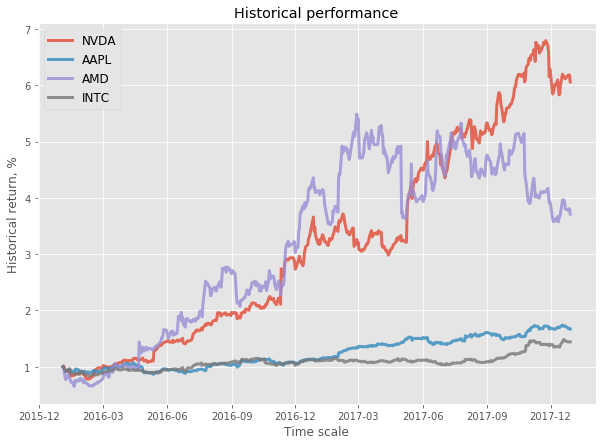

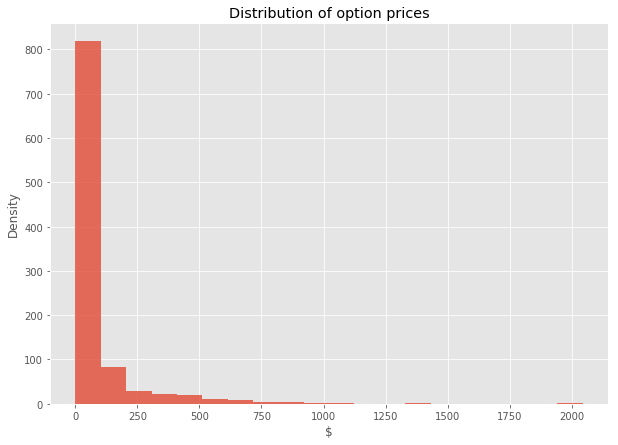

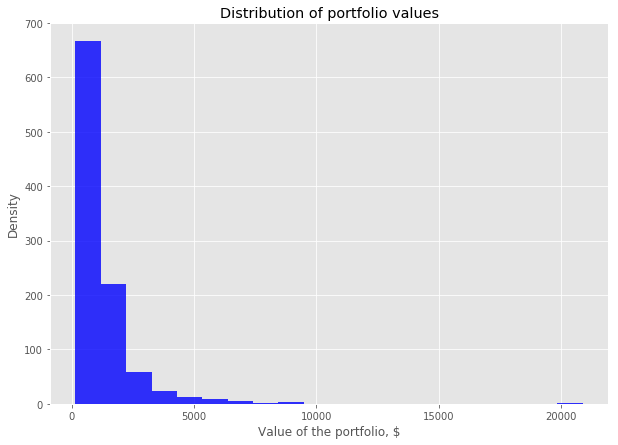

In [6]:
option.summary_plot();

----------------------------------------------------------------------------------------------------
GREEKS
Option scaled delta is -13.655
Option scaled gamma is 91.468
Option scaled speed is 39.146
----------------------------------------------------------------------------------------------------


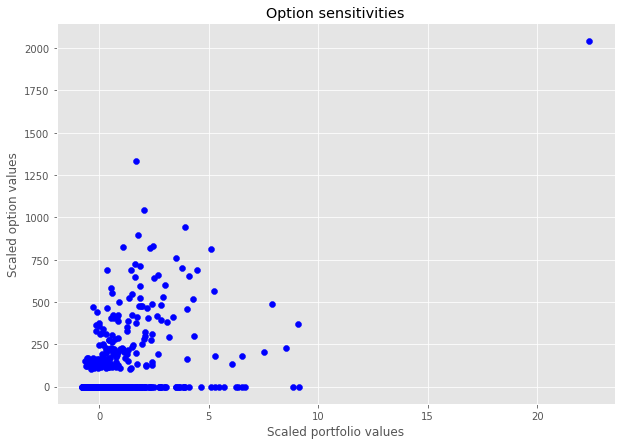

In [7]:
option.greeks();

## Заключение

1) В оценке опциона использована предпосылка о постоянсве корреляции между активами, что скорее всего не соответсвует действительности и в разные периоды бизнес цикла, корреляция между активами можно выглядеть по разному.

2) Стоимость опциона наибольшая при условии, что портфель активов собран в соотвествии с CAPM

3) Для оценки дисперсии опциона, можно посчитать implied volatilities, при условии доступности данных.